<a href="https://colab.research.google.com/github/lailamt/mate34/blob/main/Atv_IA_n_supervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bibliotecas Python

In [838]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, jaccard_score, rand_score
import plotly.express as px
import matplotlib.pyplot as plt

In [842]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Dataset

Informações sobre o dataset:



Carregando o dataset

In [973]:
filename = '/content/drive/MyDrive/Mestrado_UFBA/MATE33_IA/Datasets/Registros_da_Travessia_Salvador-Vera_Cruz.csv'

In [974]:
dataset_original = pd.read_csv(filename)

In [975]:
dataset_original.head()

,Data,Terminal,Horário,Altura da Maré (m),Velocidade do Vento (Km/h),Chuva (mm),Condição dia Anterior,Recomendação da Capitania,Resultado
0,15/03/2020,Mar grande,5:00,1.2,22.5,0.33,Bom,Verde,Saiu
1,15/03/2020,Mar grande,6:00,1.6,23.0,0.33,Bom,Verde,Saiu
2,15/03/2020,Mar grande,7:00,1.8,23.5,0.33,Bom,Verde,Saiu
3,15/03/2020,Mar grande,8:00,1.9,24.0,0.33,Bom,Verde,Saiu
4,15/03/2020,Mar grande,9:00,1.8,24.0,0.33,Bom,Verde,Saiu


##Pré-Processamento

##### Remoção da coluna "Resultado" e conversão dos valores categórigos em numéricos.

1 = Saiu / Atrasado / Adiantado

0 = Não Saiu

In [976]:
resultados = dataset_original['Resultado'].map({'Saiu':1, 'Atrasado':1, 'Adiantado':1, 'Não Saiu':0})
dataset_original = dataset_original.drop('Resultado', axis=1)
dataset_original.head()

,Data,Terminal,Horário,Altura da Maré (m),Velocidade do Vento (Km/h),Chuva (mm),Condição dia Anterior,Recomendação da Capitania
0,15/03/2020,Mar grande,5:00,1.2,22.5,0.33,Bom,Verde
1,15/03/2020,Mar grande,6:00,1.6,23.0,0.33,Bom,Verde
2,15/03/2020,Mar grande,7:00,1.8,23.5,0.33,Bom,Verde
3,15/03/2020,Mar grande,8:00,1.9,24.0,0.33,Bom,Verde
4,15/03/2020,Mar grande,9:00,1.8,24.0,0.33,Bom,Verde


In [977]:
resultados

0      1
1      1
2      1
3      1
4      1
      ..
315    0
316    1
317    1
318    1
319    0
Name: Resultado, Length: 320, dtype: int64

###### Descrição dos valores das colunas

In [978]:
dataset_original['Terminal'].unique()

array(['Mar grande', 'Salvador'], dtype=object)

In [979]:
dataset_original['Recomendação da Capitania'].unique()

array(['Verde', 'Vermelho', 'Amarelo'], dtype=object)

In [980]:
dataset_original['Condição dia Anterior'].unique()

array(['Bom', 'Ruim'], dtype=object)

In [981]:
dataset_original['Horário'].unique()

array(['5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00',
       '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '6:30',
       '7:30', '8:30', '9:30', '10:30', '11:30', '12:30', '13:30',
       '14:30', '15:30', '16:30', '17:30', '18:30', '19:30'], dtype=object)

##### Boxplots

Altura da Maré (m)

In [982]:
fig = px.box(dataset_original, x="Terminal", y="Altura da Maré (m)", color="Recomendação da Capitania", width = 1000, height = 600)
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

Velocidade do Vento (Km/h)

In [983]:
fig = px.box(dataset_original, x="Terminal", y="Velocidade do Vento (Km/h)", color="Recomendação da Capitania", width = 1000, height = 600)
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

Chuva (mm)

In [984]:
fig = px.box(dataset_original, x="Terminal", y="Chuva (mm)", color="Recomendação da Capitania", width = 1000, height = 600)
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

##### ScatterPlots

In [985]:
fig = px.scatter(dataset_original, x="Velocidade do Vento (Km/h)", y="Chuva (mm)", color="Recomendação da Capitania", width = 1000, height = 600)
fig.show()

##### Matriz de Correlação entre colunas:

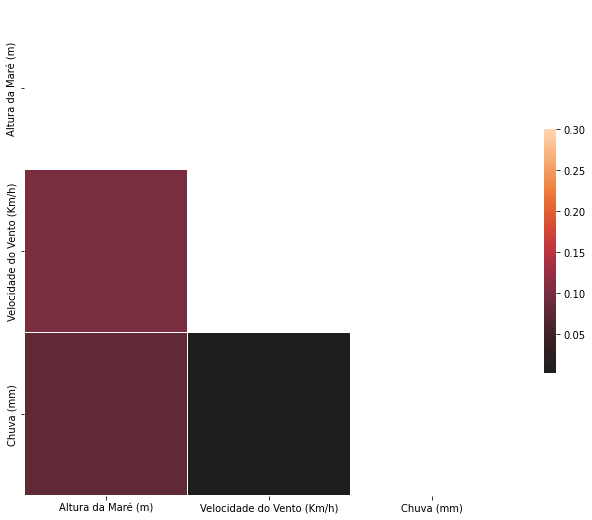

In [986]:
import matplotlib.pyplot as plt
correlations = dataset_original.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
# cmap = sns.dark_palette("seagreen")
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlations, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

####.

A coluna de horário também pode gerar variações no dataset, sendo escolhido pela equipe o uso de duas. Uma discretização que remova os horários intercalados ("5:30", "6:30", ..., "19:30") e outra que os mantenha. Com isto totalizando 4 versões do dataset para análise.

### Variações A

Troca de valores categóricos para valores númericos.

```
'Terminal' 
    'Mar grande': 0, 
    'Salvador': 1

'Condição dia Anterior' 
    'Bom': 0,
    'Ruim': 1

'Recomendação da Capitania' 
    'Verde': 0, 
    'Amarelo': 1, 
    'Vermelho': 2
```

In [987]:
dataset_a = dataset_original.copy()

In [988]:
dataset_a['Terminal'] = dataset_original['Terminal'].map({'Mar grande': 0, 'Salvador':1})
dataset_a['Condição dia Anterior'] = dataset_original['Condição dia Anterior'].map({'Bom': 0, 'Ruim':1})
dataset_a['Recomendação da Capitania'] = dataset_original['Recomendação da Capitania'].map({'Verde': 0, 'Amarelo':1, 'Vermelho':2})

In [989]:
dataset_a.head()

,Data,Terminal,Horário,Altura da Maré (m),Velocidade do Vento (Km/h),Chuva (mm),Condição dia Anterior,Recomendação da Capitania
0,15/03/2020,0,5:00,1.2,22.5,0.33,0,0
1,15/03/2020,0,6:00,1.6,23.0,0.33,0,0
2,15/03/2020,0,7:00,1.8,23.5,0.33,0,0
3,15/03/2020,0,8:00,1.9,24.0,0.33,0,0
4,15/03/2020,0,9:00,1.8,24.0,0.33,0,0


#### Variação A1

Valores da coluna 'Horário_Discreto' convertido para inteiros.

In [990]:
dataset_a1 = dataset_a.copy()

In [991]:
dataset_a1['Horário_Discreto'] = dataset_a1['Horário'].map({'5:00':5, '5:30':5, '6:00':6, '6:30':6, '7:00':7, '7:30':7,
                                                           '8:00':8, '8:30':8, '9:00':9, '9:30':9, '10:00':10, '10:30':10,
                                                           '11:00':11, '11:30':11, '12:00':12, '12:30':12, '13:00':13, '13:30':13,
                                                           '14:00':14, '14:30':14, '15:00':15, '15:30':15, '16:00':16, '16:30':16,
                                                           '17:00':17, '17:30':17, '18:00':18, '18:30':18, '19:00':19, '19:30':19})
dataset_a1 = dataset_a1.drop('Data', axis=1)
dataset_a1 = dataset_a1.drop('Horário', axis=1)
for i in ['Altura da Maré (m)', 'Velocidade do Vento (Km/h)', 'Chuva (mm)']:
    dataset_a1[i] = dataset_a1[i].astype(float)

In [992]:
dataset_a1

,Terminal,Altura da Maré (m),Velocidade do Vento (Km/h),Chuva (mm),Condição dia Anterior,Recomendação da Capitania,Horário_Discreto
0,0,1.2,22.5,0.33,0,0,5
1,0,1.6,23.0,0.33,0,0,6
2,0,1.8,23.5,0.33,0,0,7
3,0,1.9,24.0,0.33,0,0,8
4,0,1.8,24.0,0.33,0,0,9
...,...,...,...,...,...,...,...
315,0,2.5,18.5,0.83,1,2,16
316,1,1.6,10.5,0.83,1,2,6
317,1,-0.1,7.5,0.83,1,2,9
318,1,2.0,14.0,0.83,1,2,14


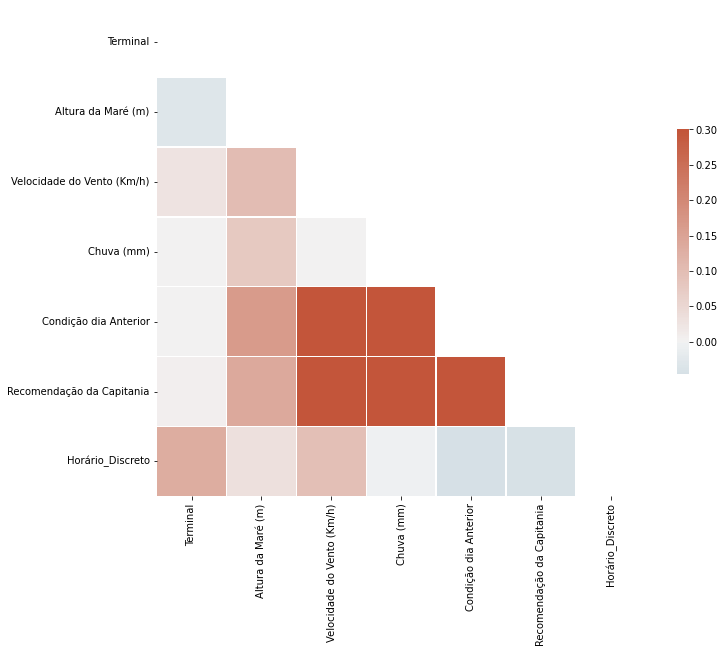

In [993]:
import matplotlib.pyplot as plt
correlations = dataset_a1.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

####Variação A2

Valores da coluna 'Horário_Discreto' convertido para reais.

In [994]:
dataset_a2 = dataset_a.copy()

In [995]:
dataset_a2['Horário_Discreto'] = dataset_a2['Horário'].map({'5:00':5, '5:30':5.5, '6:00':6, '6:30':6.5, '7:00':7, '7:30':7.5,
                                                           '8:00':8, '8:30':8.5, '9:00':9, '9:30':9.5, '10:00':10, '10:30':10.5,
                                                           '11:00':11, '11:30':11.5, '12:00':12, '12:30':12.5, '13:00':13, '13:30':13.5,
                                                           '14:00':14, '14:30':14.5, '15:00':15, '15:30':15.5, '16:00':16, '16:30':16.5,
                                                           '17:00':17, '17:30':17.5, '18:00':18, '18:30':18.5, '19:00':19, '19:30':19.5})
dataset_a2 = dataset_a2.drop('Data', axis=1)
dataset_a2 = dataset_a2.drop('Horário', axis=1)
for i in ['Altura da Maré (m)', 'Velocidade do Vento (Km/h)', 'Chuva (mm)']:
    dataset_a2[i] = dataset_a2[i].astype(float)

In [996]:
dataset_a2

,Terminal,Altura da Maré (m),Velocidade do Vento (Km/h),Chuva (mm),Condição dia Anterior,Recomendação da Capitania,Horário_Discreto
0,0,1.2,22.5,0.33,0,0,5.0
1,0,1.6,23.0,0.33,0,0,6.0
2,0,1.8,23.5,0.33,0,0,7.0
3,0,1.9,24.0,0.33,0,0,8.0
4,0,1.8,24.0,0.33,0,0,9.0
...,...,...,...,...,...,...,...
315,0,2.5,18.5,0.83,1,2,16.5
316,1,1.6,10.5,0.83,1,2,6.5
317,1,-0.1,7.5,0.83,1,2,9.5
318,1,2.0,14.0,0.83,1,2,14.5


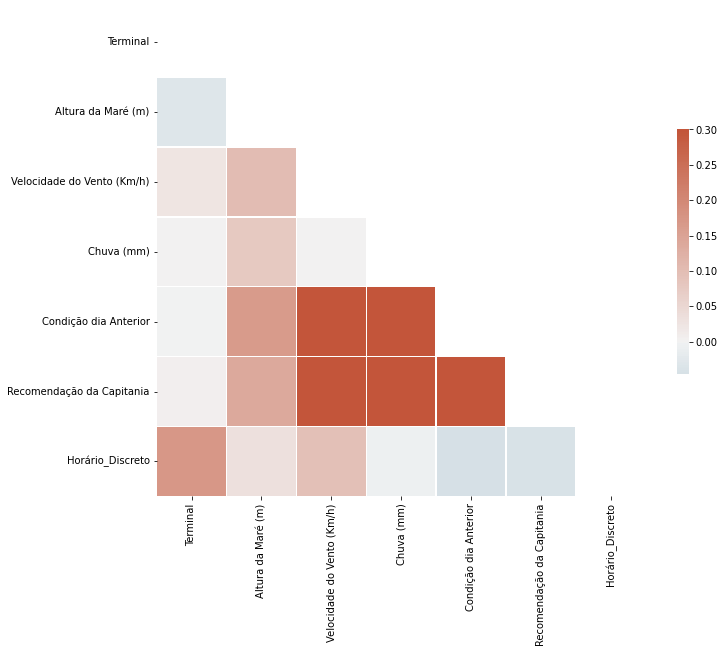

In [997]:
import matplotlib.pyplot as plt
correlations = dataset_a2.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Variações B

Dummieficação das colunas 'Terminal', 'Condição dia Anterior' e 'Recomendação da Capitania'.

In [998]:
dataset_b = dataset_original.copy()

In [999]:
dataset_b = pd.get_dummies(dataset_b, columns=['Terminal','Condição dia Anterior','Recomendação da Capitania'])

In [1000]:
dataset_b

,Data,Horário,Altura da Maré (m),Velocidade do Vento (Km/h),Chuva (mm),Terminal_Mar grande,Terminal_Salvador,Condição dia Anterior_Bom,Condição dia Anterior_Ruim,Recomendação da Capitania_Amarelo,Recomendação da Capitania_Verde,Recomendação da Capitania_Vermelho
0,15/03/2020,5:00,1.2,22.5,0.33,1,0,1,0,0,1,0
1,15/03/2020,6:00,1.6,23.0,0.33,1,0,1,0,0,1,0
2,15/03/2020,7:00,1.8,23.5,0.33,1,0,1,0,0,1,0
3,15/03/2020,8:00,1.9,24.0,0.33,1,0,1,0,0,1,0
4,15/03/2020,9:00,1.8,24.0,0.33,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
315,08/05/2020,16:30,2.5,18.5,0.83,1,0,0,1,0,0,1
316,08/05/2020,6:30,1.6,10.5,0.83,0,1,0,1,0,0,1
317,08/05/2020,9:30,-0.1,7.5,0.83,0,1,0,1,0,0,1
318,08/05/2020,14:30,2.0,14.0,0.83,0,1,0,1,0,0,1


#### Variação B1

Valores da coluna 'Horário_Discreto' convertido para inteiros.

In [1001]:
dataset_b1 = dataset_b.copy()

In [1002]:
dataset_b1['Horário_Discreto'] = dataset_b1['Horário'].map({'5:00':5, '5:30':5, '6:00':6, '6:30':6, '7:00':7, '7:30':7,
                                                           '8:00':8, '8:30':8, '9:00':9, '9:30':9, '10:00':10, '10:30':10,
                                                           '11:00':11, '11:30':11, '12:00':12, '12:30':12, '13:00':13, '13:30':13,
                                                           '14:00':14, '14:30':14, '15:00':15, '15:30':15, '16:00':16, '16:30':16,
                                                           '17:00':17, '17:30':17, '18:00':18, '18:30':18, '19:00':19, '19:30':19})
dataset_b1 = dataset_b1.drop('Data', axis=1)
dataset_b1 = dataset_b1.drop('Horário', axis=1)
for i in ['Altura da Maré (m)', 'Velocidade do Vento (Km/h)', 'Chuva (mm)']:
    dataset_b1[i] = dataset_b1[i].astype(float)

In [1003]:
dataset_b1

,Altura da Maré (m),Velocidade do Vento (Km/h),Chuva (mm),Terminal_Mar grande,Terminal_Salvador,Condição dia Anterior_Bom,Condição dia Anterior_Ruim,Recomendação da Capitania_Amarelo,Recomendação da Capitania_Verde,Recomendação da Capitania_Vermelho,Horário_Discreto
0,1.2,22.5,0.33,1,0,1,0,0,1,0,5
1,1.6,23.0,0.33,1,0,1,0,0,1,0,6
2,1.8,23.5,0.33,1,0,1,0,0,1,0,7
3,1.9,24.0,0.33,1,0,1,0,0,1,0,8
4,1.8,24.0,0.33,1,0,1,0,0,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...
315,2.5,18.5,0.83,1,0,0,1,0,0,1,16
316,1.6,10.5,0.83,0,1,0,1,0,0,1,6
317,-0.1,7.5,0.83,0,1,0,1,0,0,1,9
318,2.0,14.0,0.83,0,1,0,1,0,0,1,14


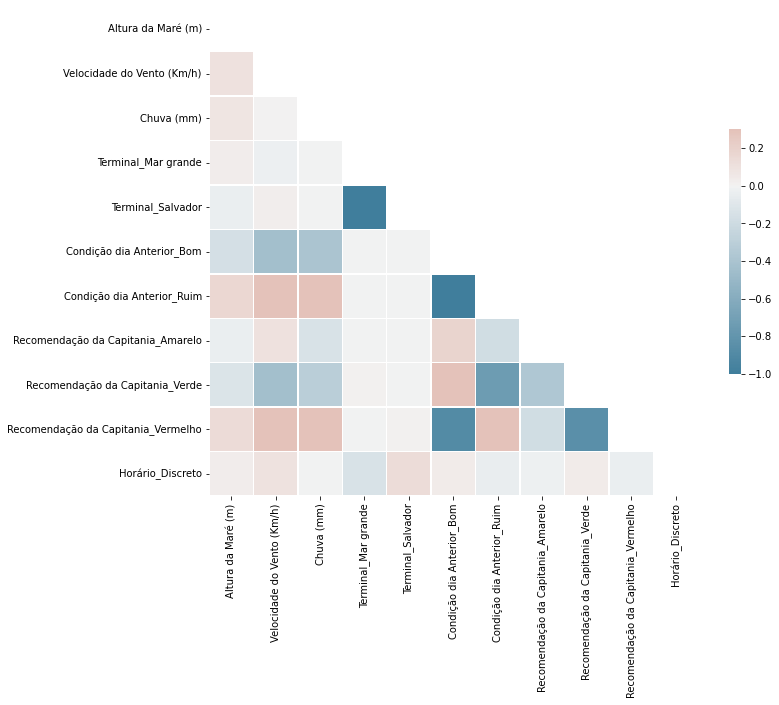

In [1004]:
import matplotlib.pyplot as plt
correlations = dataset_b1.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Variação B2

Valores da coluna 'Horário_Discreto' convertido para reais.

In [1005]:
dataset_b2 = dataset_b.copy()

In [1006]:
dataset_b2['Horário_Discreto'] = dataset_b2['Horário'].map({'5:00':5, '5:30':5.5, '6:00':6, '6:30':6.5, '7:00':7, '7:30':7.5,
                                                           '8:00':8, '8:30':8.5, '9:00':9, '9:30':9.5, '10:00':10, '10:30':10.5,
                                                           '11:00':11, '11:30':11.5, '12:00':12, '12:30':12.5, '13:00':13, '13:30':13.5,
                                                           '14:00':14, '14:30':14.5, '15:00':15, '15:30':15.5, '16:00':16, '16:30':16.5,
                                                           '17:00':17, '17:30':17.5, '18:00':18, '18:30':18.5, '19:00':19, '19:30':19.5})
dataset_b2 = dataset_b2.drop('Data', axis=1)
dataset_b2 = dataset_b2.drop('Horário', axis=1)
for i in ['Altura da Maré (m)', 'Velocidade do Vento (Km/h)', 'Chuva (mm)']:
    dataset_b2[i] = dataset_b2[i].astype(float)

In [1007]:
dataset_b2

,Altura da Maré (m),Velocidade do Vento (Km/h),Chuva (mm),Terminal_Mar grande,Terminal_Salvador,Condição dia Anterior_Bom,Condição dia Anterior_Ruim,Recomendação da Capitania_Amarelo,Recomendação da Capitania_Verde,Recomendação da Capitania_Vermelho,Horário_Discreto
0,1.2,22.5,0.33,1,0,1,0,0,1,0,5.0
1,1.6,23.0,0.33,1,0,1,0,0,1,0,6.0
2,1.8,23.5,0.33,1,0,1,0,0,1,0,7.0
3,1.9,24.0,0.33,1,0,1,0,0,1,0,8.0
4,1.8,24.0,0.33,1,0,1,0,0,1,0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
315,2.5,18.5,0.83,1,0,0,1,0,0,1,16.5
316,1.6,10.5,0.83,0,1,0,1,0,0,1,6.5
317,-0.1,7.5,0.83,0,1,0,1,0,0,1,9.5
318,2.0,14.0,0.83,0,1,0,1,0,0,1,14.5


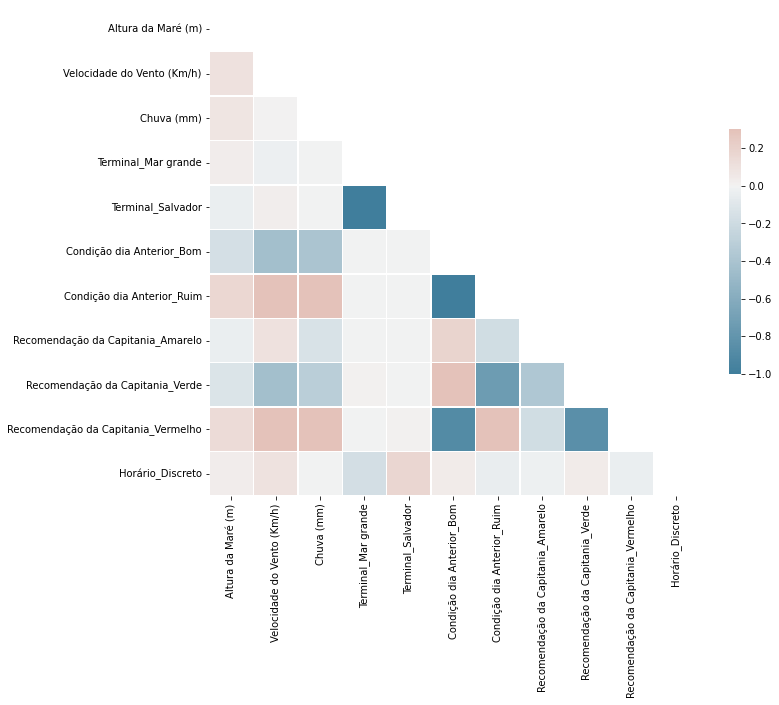

In [1008]:
import matplotlib.pyplot as plt
correlations = dataset_b2.corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Algoritmos de ML e Validação

###Funções para plotagens

In [1009]:
def show_scatter(df, cluster, centroids):
    for i in np.unique(cluster):
        plt.scatter(df[cluster == i]['Velocidade do Vento (Km/h)'], df[cluster == i]['Chuva (mm)'], label=i)
        plt.scatter(centroids[:,0] , centroids[:,1] , s = 80)
    plt.legend()
    plt.show()

In [1010]:
def show_scatter_no_centroids(df, cluster):
    for i in np.unique(cluster):
        plt.scatter(df[cluster == i]['Velocidade do Vento (Km/h)'], df[cluster == i]['Chuva (mm)'], label=i)
    plt.legend()
    plt.show()

In [1011]:
def show_silhouette(values, range):
    fig = px.bar(val_analises_df, y='silhouette', x='variation',
                title = 'Silhouette values', text = 'silhouette',
                color='variation', range_y=range, width = 800, height = 600)
    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig.show()

In [1012]:
def show_jaccard(values, range):
    fig = px.bar(values, y='jaccard', x='variation',
                title = 'Jaccard values', text = 'jaccard',
                color='variation', range_y=range, width = 800, height = 600)
    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig.show()

In [1013]:
def show_scatter_data(df, cluster):
    for i in np.unique(cluster):
        plt.scatter(df[cluster == i]['Velocidade do Vento (Km/h)'], df[cluster == i]['Chuva (mm)'], label=i)
    fig.show()

In [1014]:
def show_3d_clusters(df):
    fig = px.scatter_3d(df, x = 'Altura da Maré (m)', y='Velocidade do Vento (Km/h)', z='Chuva (mm)', color='Cluster', 
                    title = '3d scatter clusters',
                    opacity = 0.8, width = 1100, height = 600)
    fig.show()

### K-Means

In [1015]:
kmeans = KMeans(n_clusters=2, random_state=123456) # random_state= semente aleatoria
valores_analise = {
    'jaccard': [],
    'silhouette': [],
    'variation': []
    }

#### Variação A1

In [1016]:
clustering_a1 = kmeans.fit_predict(dataset_a1)
valores_analise['silhouette'].append(silhouette_score(dataset_a1, clustering_a1))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_a1, average='macro'))
valores_analise['variation'].append('A1')

##### Clusters da variação A1 (Kmeans)

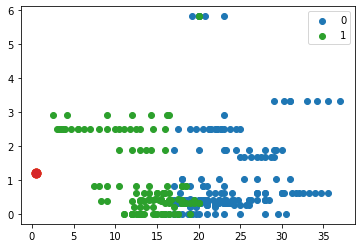

In [1017]:
centroids = kmeans.cluster_centers_
show_scatter(dataset_a1, clustering_a1, centroids)

In [1018]:
dataset_a1_cluster = dataset_a1.copy()
dataset_a1_cluster['Cluster'] = clustering_a1

show_3d_clusters(dataset_a1_cluster)

#### Variação A2

In [1019]:
clustering_a2 = kmeans.fit_predict(dataset_a2)
valores_analise['silhouette'].append(silhouette_score(dataset_a2, clustering_a2))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_a2, average='macro'))
valores_analise['variation'].append('A2')

##### Clusters da variação A2 (Kmeans)

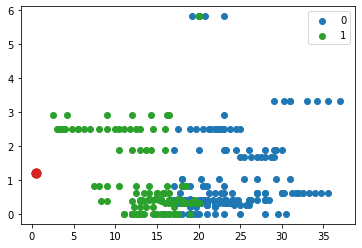

In [1020]:
centroids = kmeans.cluster_centers_
show_scatter(dataset_a2, clustering_a2, centroids)

In [1021]:
dataset_a2_cluster = dataset_a2.copy()
dataset_a2_cluster['Cluster'] = clustering_a2

show_3d_clusters(dataset_a2_cluster)

#### Variação B1

In [1022]:
clustering_b1 = kmeans.fit_predict(dataset_b1)
valores_analise['silhouette'].append(silhouette_score(dataset_b1, clustering_b1))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_b1, average='macro'))
valores_analise['variation'].append('B1')

##### Clusters da Variação B1 (Kmeans)

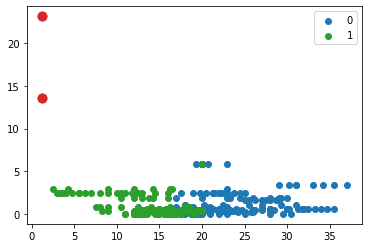

In [1023]:
centroids = kmeans.cluster_centers_
show_scatter(dataset_b1, clustering_b1, centroids)

In [1024]:
dataset_b1_cluster = dataset_b1.copy()
dataset_b1_cluster['Cluster'] = clustering_b1

show_3d_clusters(dataset_b1_cluster)

#### Variação B2

In [1025]:
clustering_b2 = kmeans.fit_predict(dataset_b2)
valores_analise['silhouette'].append(silhouette_score(dataset_b2, clustering_b2))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_b2, average='macro'))
valores_analise['variation'].append('B2')

##### Clusters da Variação B2 (Kmeans)

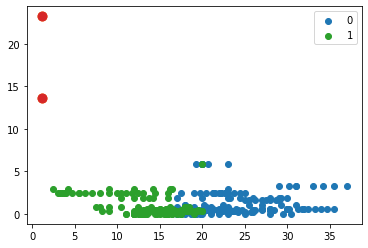

In [1026]:
centroids = kmeans.cluster_centers_
show_scatter(dataset_b2, clustering_b2, centroids)

In [1027]:
dataset_b2_cluster = dataset_b2.copy()
dataset_b2_cluster['Cluster'] = clustering_b2

show_3d_clusters(dataset_b2_cluster)

#### Métricas de Avaliação

In [1028]:
val_analises_df = pd.DataFrame(valores_analise)

O Coeficiente de Silhueta é calculado usando a distância média intra-cluster ($a$) e a distância média do cluster mais próximo ($b$) para cada amostra. O coeficiente de silhueta para uma amostra é $\frac{(b - a)}{max(a, b)}$. Para esclarecer, $b$ é a distância entre uma amostra e o cluster mais próximo do qual a amostra não faz parte. Observe que o Coeficiente de Silhueta só é definido se o número de rótulos for $2 <= n_{labels} <= n_{samples} - 1$.

Esta função retorna o Coeficiente de Silhueta médio de todas as amostras. 

O melhor valor é $1$ e o pior valor é $-1$. Valores próximos a $0$ indicam clusters sobrepostos. Valores negativos geralmente indicam que uma amostra foi atribuída ao cluster errado, pois um cluster diferente é mais semelhante.

In [1029]:
show_silhouette(val_analises_df, [0.3, 0.4])

O índice de Jaccard, ou coeficiente de similaridade de Jaccard, definido como o tamanho da interseção dividido pelo tamanho da união de dois conjuntos de rótulos, é usado para comparar o conjunto de rótulos previstos para uma amostra com o conjunto de rótulos correspondente em y_true .

A função `jaccard_score` calcula a média dos coeficientes de similaridade de Jaccard, também chamada de índice de Jaccard, entre pares de conjuntos de rótulos.

O coeficiente de similaridade de Jaccard das i-ésimas amostras, com um conjunto de rótulos de verdade $y_i$ e um conjunto de rótulos previstos $\hat{y}_i$, é definido como
$$
J(y_i,\hat{y}_i) = \frac{ |y_i \cap \hat{y}_i| }{ |y_i \cup \hat{y}_i| }
$$

In [1030]:
show_jaccard(val_analises_df, [0.2, 0.3])

### Hierárquico Aglomerativo

Começa com *n* clusters com um único objeto e forma a sequência de partições agrupando os clusters sucessivamente

In [1031]:
hierarquico = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                     linkage = 'average')
valores_analise = {
    'jaccard': [],
    'silhouette': [],
    'variation': []
    }

##### Variação A1

In [1032]:
clustering_a1 = hierarquico.fit_predict(dataset_a1)
valores_analise['silhouette'].append(silhouette_score(dataset_a1, clustering_a1))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_a1, average='macro'))
valores_analise['variation'].append('A1')

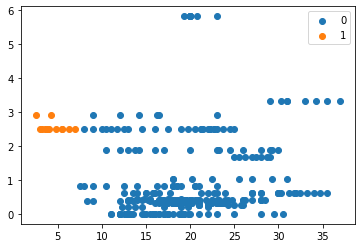

In [1033]:
show_scatter_no_centroids(dataset_a1, clustering_a1)

In [1034]:
dataset_a1_cluster = dataset_a1.copy()
dataset_a1_cluster['Cluster'] = clustering_a1

show_3d_clusters(dataset_a1_cluster)

##### Variação A2

In [1035]:
clustering_a2 = hierarquico.fit_predict(dataset_a2)
valores_analise['silhouette'].append(silhouette_score(dataset_a2, clustering_a2))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_a2, average='macro'))
valores_analise['variation'].append('A2')

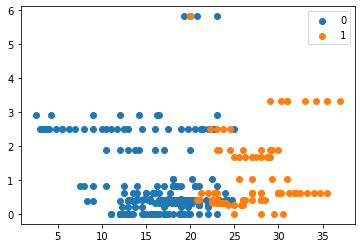

In [1036]:
show_scatter_no_centroids(dataset_a2, clustering_a2)

In [1037]:
dataset_a2_cluster = dataset_a2.copy()
dataset_a2_cluster['Cluster'] = clustering_a2

show_3d_clusters(dataset_a2_cluster)

##### Variação B1

In [1038]:
clustering_b1 = hierarquico.fit_predict(dataset_b1)
valores_analise['silhouette'].append(silhouette_score(dataset_b1, clustering_b1))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_b1, average='macro'))
valores_analise['variation'].append('B1')

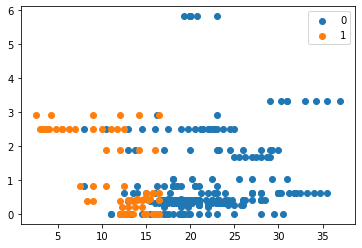

In [1039]:
show_scatter_no_centroids(dataset_b1, clustering_b1)

In [1040]:
dataset_b1_cluster = dataset_b1.copy()
dataset_b1_cluster['Cluster'] = clustering_b1

show_3d_clusters(dataset_b1_cluster)

##### Variação B2

In [1041]:
clustering_b2 = hierarquico.fit_predict(dataset_b2)
valores_analise['silhouette'].append(silhouette_score(dataset_b2, clustering_b2))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_b2, average='macro'))
valores_analise['variation'].append('B2')

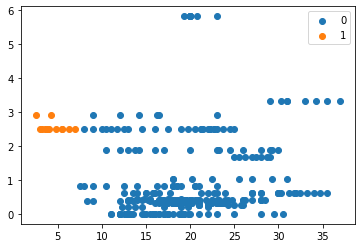

In [1042]:
show_scatter_no_centroids(dataset_b2, clustering_b2)

In [1043]:
dataset_b2_cluster = dataset_b2.copy()
dataset_b2_cluster['Cluster'] = clustering_b2

show_3d_clusters(dataset_b2_cluster)

##### Análise dos resultados Hierarquico


In [1044]:
val_analises_df = pd.DataFrame(valores_analise)

O Coeficiente de Silhueta é calculado usando a distância média intra-cluster ($a$) e a distância média do cluster mais próximo ($b$) para cada amostra. O coeficiente de silhueta para uma amostra é $\frac{(b - a)}{max(a, b)}$. Para esclarecer, $b$ é a distância entre uma amostra e o cluster mais próximo do qual a amostra não faz parte. Observe que o Coeficiente de Silhueta só é definido se o número de rótulos for $2 <= n_{labels} <= n_{samples} - 1$.

Esta função retorna o Coeficiente de Silhueta médio de todas as amostras. 

O melhor valor é $1$ e o pior valor é $-1$. Valores próximos a $0$ indicam clusters sobrepostos. Valores negativos geralmente indicam que uma amostra foi atribuída ao cluster errado, pois um cluster diferente é mais semelhante.

In [1045]:
show_silhouette(val_analises_df, [0.3, 0.4])

O índice de Jaccard, ou coeficiente de similaridade de Jaccard, definido como o tamanho da interseção dividido pelo tamanho da união de dois conjuntos de rótulos, é usado para comparar o conjunto de rótulos previstos para uma amostra com o conjunto de rótulos correspondente em y_true .

A função `jaccard_score` calcula a média dos coeficientes de similaridade de Jaccard, também chamada de índice de Jaccard, entre pares de conjuntos de rótulos.

O coeficiente de similaridade de Jaccard das i-ésimas amostras, com um conjunto de rótulos de verdade $y_i$ e um conjunto de rótulos previstos $\hat{y}_i$, é definido como
$$
J(y_i,\hat{y}_i) = \frac{ |y_i \cap \hat{y}_i| }{ |y_i \cup \hat{y}_i| }
$$

In [1046]:
show_jaccard(val_analises_df, [0.0, 0.2])

###.

Podemos reconhecer com estes valores que, os clusters formados não se provam como sendo bem relevantes, existindo uma fraca relação que defina cada entrada de dados como sendo parte de um agrupamento.

## Uso de abordagens para a análise da quantidade de clusters

### Análise da quantidade de clusters - Kmeans

In [1047]:
import plotly.graph_objects as go
import math

O K-means começa com a alocação aleatória de centros de cluster e, em seguida, procura soluções "melhores". Uma coisa sobre esse algoritmo é que é necessário fornecer o número de clusters de antemão, então, numa abordagem não supervisionada quais técnicas podem ser utilizadas para inferir um número de clusters? 

Uma forma de realizar essa análise é através do Método Cotovelo, a ideia é rodar o KMeans para vários quantidades diferentes de clusters e dizer qual dessas quantidades é o número ótimo de clusters. O que geralmente acontece ao aumentar a quantidade de clusters no KMeans é que as diferenças entre clusters se tornam muito pequenas, e as diferenças das observações intra-clusters vão aumentando. Então é preciso achar um equilíbrio em que as observações que formam cada agrupamento sejam o mais homogêneas possível e que os agrupamentos formados sejam o mais diferentes um dos outros.

Como o KMeans calcula a distância das observações até o centro do agrupamento que ela pertence, o ideal é que essa distância seja a menor viável. Matematicamente falando, nós estamos buscando uma quantidade de agrupamentos em que a soma dos quadrados intra-clusters (ou do inglês *within-clusters sum-of-squares*, comumente abreviado para wcss) seja a menor possível, sendo zero o resultado ótimo.
O KMeans do scikit-learn já calcula o wcss pra gente e dá o nome de `inertia`.

In [1048]:
def calculate_wcss(data):
    wcss = []
    for n in range(1, 10):
        kmeans = KMeans(n_clusters=n, init = "k-means++", n_init = 10, random_state = 123)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    return wcss

In [1049]:
wcss = calculate_wcss(dataset_a1)
fig = go.Figure(data = go.Scatter(x = [1,2,3,4,5,6,7,8,9,10], y = wcss))

fig.update_layout(title='WCSS vs. Cluster number',
                   xaxis_title='Clusters',
                   yaxis_title='WCSS', width = 800, height = 400)
fig.show()

Mas qual desses pontos seria o ponto ótimo de clusters?

O ponto que indica o equilíbrio entre maior homogeneidade dentro do cluster e a maior diferença entre clusters, é o ponto da curva mais distante de uma reta traçada ligando os pontos 1 e 9. Para encontrar este ponto basta utilizarmos a equação de cálculo da distância entre um ponto e uma reta.

In [1050]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 1, wcss[0]
    x2, y2 = 10, wcss[len(wcss)-1]

    # Calcula as distâncias entre os pontos e a reta
    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

Esse método `optimal_number_of_clusters()` recebe uma lista contendo as somas dos quadrados para cada quantidade de clusters que calculamos usando `calculate_wcss()` e, como resultado, retorna a quantidade ótima de clusters.

In [1051]:
# calculando a quantidade ótima de clusters
n = optimal_number_of_clusters(wcss)
print(f'Número ótimo de clusters indicado: {n}')

Número ótimo de clusters indicado: 4


[Artigo de referência](https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9)

#### KMeans (4 Clusters)

In [1052]:
kmeans = KMeans(n_clusters=4, random_state=123456) # random_state= semente aleatoria
valores_analise = {
    'jaccard': [],
    'silhouette': [],
    'variation': []
    }

In [1053]:
clustering_a1 = kmeans.fit_predict(dataset_a1)
valores_analise['silhouette'].append(silhouette_score(dataset_a1, clustering_a1))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_a1, average='macro'))
valores_analise['variation'].append('A1')

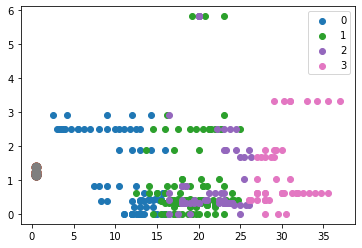

In [1054]:
centroids = kmeans.cluster_centers_
show_scatter(dataset_a1, clustering_a1, centroids)

In [1055]:
dataset_a1_cluster['Cluster'] = clustering_a1

show_3d_clusters(dataset_a1_cluster)

In [1056]:
print('Coeficiente de Jaccard: {:.3f}'.format(valores_analise['jaccard'][0]))
print('Silhueta: {:.3f}'.format(valores_analise['silhouette'][0]))

Coeficiente de Jaccard: 0.121
Silhueta: 0.393


### Análise da quantidade de clusters - Hierárquico

In [1057]:
import scipy.cluster.hierarchy as sch
import plotly.figure_factory as ff

No agrupamento aglomerativo hierárquico, cada ponto passa a ser um agrupamento individual, e eles se agrupam levando em consideração a distância entre cada um (primeiro os mais próximos). 

Para ter uma ideia melhor do número de clusters, podemos utilizar um dendrograma.

O corte de um dendograma na horizontal representa uma partição.

In [1058]:
fig = ff.create_dendrogram(dataset_a1,
                           linkagefun = lambda x: sch.linkage(x, "ward"),)
fig.update_layout(title = 'Hierarchical Clustering',
                   yaxis_title='Euclidean Distance', width=1100, height=600)

fig.show()

#### Hierárquico (3 Clusters)

In [1059]:
hierarquico = AgglomerativeClustering(n_clusters=3, affinity='euclidean', 
                                     linkage = 'average')
valores_analise = {
    'jaccard': [],
    'silhouette': [],
    'variation': []
    }

In [1060]:
clustering_a1 = hierarquico.fit_predict(dataset_a1)
valores_analise['silhouette'].append(silhouette_score(dataset_a1, clustering_a1))
valores_analise['jaccard'].append(jaccard_score(resultados, clustering_a1, average='macro'))
valores_analise['variation'].append('A1')

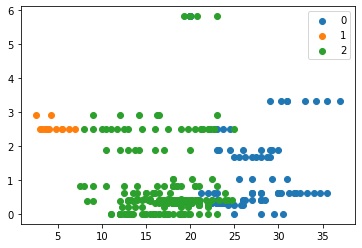

In [1061]:
show_scatter_no_centroids(dataset_a1, clustering_a1)

In [1062]:
dataset_a1_cluster = dataset_a1.copy()
dataset_a1_cluster['Cluster'] = clustering_a1

show_3d_clusters(dataset_a1_cluster)

In [1063]:
print('Coeficiente de Jaccard: {:.3f}'.format(valores_analise['jaccard'][0]))
print('Silhueta: {:.3f}'.format(valores_analise['silhouette'][0]))

Coeficiente de Jaccard: 0.091
Silhueta: 0.308


##DBSCAN

In [1064]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [1082]:
X = dataset_a1.copy()
db = DBSCAN(eps=3.2, min_samples=7).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Estimated number of noise points: 17
Silhouette Coefficient: 0.196


In [1083]:
X['Cluster'] = labels

show_3d_clusters(X)